In [1]:
%matplotlib notebook

from __future__ import print_function, absolute_import, division
import numpy as np
import tables
from heartnet_v1 import reshape_folds
from keras.utils import to_categorical
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from keras.models import model_from_json
from custom_layers import Conv1D_linearphaseType, Conv1D_linearphase, DCT1D, \
            Conv1D_gammatone, Conv1D_linearphaseType_legacy, Conv1D_zerophase
    
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
from scipy import signal
from imblearn.under_sampling import RandomUnderSampler
sns.set()
sns.set_style('whitegrid')

Using TensorFlow backend.


## Utils

In [2]:
def get_activations(model, model_inputs, batch_size=64,print_shape_only=True, layer_name=None):
    '''
    Get activations from a specific layer of a trained model
    '''
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    
    start_idx = 0
    for idx in range(batch_size,len(model_inputs)+batch_size,batch_size):
#         print(batch_size)
        if model_multi_inputs_cond:
            raise NotImplementedError
        else:
            list_inputs = [model_inputs[start_idx:idx], 0.]

        # Learning phase. 0 = Test mode (no dropout or batch normalization)
        # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
        layer_outputs = [func(list_inputs)[0] for func in funcs]
        for layer_activations in layer_outputs:
            activations.append(layer_activations)
        start_idx = idx
    return np.vstack(activations)


def display_activations(activation_maps):
    '''
    Plot activations
    '''
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
    plt.show()

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.asarray(smoothed)
    
def get_weights(log_name,min_metric=.7,min_epoch=50,verbose=1,log_dir='/media/taufiq/Data1/heart_sound/logs'):
    '''
    Load weights from training.csv file
    '''
#     log_dir = '/media/taufiq/Data1/heart_sound/logs'
    
    if not os.path.isdir(os.path.join(log_dir,log_name)):
        log_dir = '/media/taufiq/Data1/heart_sound/logArxiv'
    training_csv = os.path.join(log_dir,log_name,"training.csv")
    df = pd.read_csv(training_csv)
    sens_idx = df['val_sensitivity'][df.epoch>min_epoch][df.val_specificity>min_metric].idxmax()
    spec_idx = df['val_specificity'][df.epoch>min_epoch][df.val_sensitivity>min_metric].idxmax()
    macc_idx = df['val_macc'][df.epoch>min_epoch].idxmax()
    val_idx = df['val_acc'][df.epoch>min_epoch].idxmax()
    weights = dict()
    weights['val_sensitivity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[sens_idx]+1,df.val_acc.iloc[sens_idx])
    weights['val_specificity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[spec_idx]+1,df.val_acc.iloc[spec_idx])
    weights['val_macc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[macc_idx]+1,df.val_acc.iloc[macc_idx])
    weights['val_acc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[val_idx]+1,df.val_acc.iloc[val_idx])
    weights['epoch'] = ["weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[idx]+1,df.val_acc.iloc[idx]) 
                        for idx in range(df.count()[0])]
    
    if verbose:
        print("Best Sensitivity model: {} \t\t{}".format(df.val_sensitivity.iloc[sens_idx],weights['val_sensitivity']))
        print("Best Specificity model: {} \t\t{}".format(df.val_specificity.iloc[spec_idx],weights['val_specificity']))
        print("Best Macc model: {} \t\t{}".format(df.val_macc.iloc[macc_idx],weights['val_macc']))
        print("Best Val model: {} \t\t\t{}".format(df.val_acc.iloc[val_idx],weights['val_acc']))
    return weights

      
def load_data(foldname,fold_dir=None,_categorical=True,quality=False):
    ## import data
    if fold_dir is None:
        fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/folds_dec_2018/'
    
    feat = tables.open_file(fold_dir + foldname + '.mat')
    x_train = feat.root.trainX[:]
    y_train = feat.root.trainY[0, :]
    q_train = feat.root.trainY[1, :]
    x_val = feat.root.valX[:]
    y_val = feat.root.valY[0, :]
    q_val = feat.root.valY[1, :]
    train_parts = feat.root.train_parts[:]
    val_parts = feat.root.val_parts[0, :]

    ############## Relabeling ################
    
    for i in range(0, y_train.shape[0]):
        if y_train[i] == -1:
            y_train[i] = 0  ## Label 0 for normal 1 for abnormal
    for i in range(0, y_val.shape[0]):
        if y_val[i] == -1:
            y_val[i] = 0

    ############# Parse Database names ########

    train_files = []
    for each in feat.root.train_files[:][0]:
        train_files.append(chr(each))
    print(len(train_files))
    val_files = []
    for each in feat.root.val_files[:][0]:
        val_files.append(chr(each))
    print(len(val_files))

    ################### Reshaping ############

    x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)

    if _categorical:
        y_train = to_categorical(y_train, num_classes=2)
        y_val = to_categorical(y_val, num_classes=2)
    
    if quality:
        return x_train, y_train, train_files, train_parts, q_train, \
                x_val, y_val, val_files, val_parts, q_val
    else:
        return x_train, y_train, train_files, train_parts, \
                x_val, y_val, val_files, val_parts

def load_model(log_name,verbose=0,
               model_dir='/media/taufiq/Data1/heart_sound/models/',
               log_dir='/media/taufiq/Data1/heart_sound/logs/'):
    
#     model_dir = '/media/taufiq/Data1/heart_sound/models/'
#     log_dir = '/media/taufiq/Data1/heart_sound/logs/'

    if os.path.isdir(model_dir+log_name):
        print("Model directory found")
        if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
            print("model.json found. Importing")
        else:
            raise ImportError("model.json not found")

    with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
        loaded_model_json = json_file.read()
    try:
        model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,
                                               'DCT1D':DCT1D,
                                               'Conv1D_linearphaseType':Conv1D_linearphaseType,
                                               'Conv1D_gammatone' : Conv1D_gammatone,
                                                'Conv1D_zerophase' : Conv1D_zerophase,
                                              })
    except:
        model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,
                                               'DCT1D':DCT1D,
                                               'Conv1D_linearphaseType':Conv1D_linearphaseType_legacy,
                                               'Conv1D_gammatone' : Conv1D_gammatone,
                                                   'Conv1D_zerophase' : Conv1D_zerophase,
                                              })
    if verbose:
        print(log_name)
        model.summary()
    return model

def cc2parts(cc,parts):
    
    if not len(cc) == sum(parts):
        raise ValueError('Number of CC elements are not equal to total number of parts')
    
    labels = []
    start_idx = 0
#     cc = np.round(cc)
    
    for s in parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        temp = cc[start_idx:start_idx + int(s)]
        try:
            labels.append(np.mean(temp,axis=0))
        except TypeError: ## TypeError for string input in train_files
            labels.append(cc[start_idx])
        start_idx = start_idx + int(s)
    return np.asarray(labels)

def parts2cc(partitioned,parts):
    
    labels = []
    parts = parts[np.nonzero(parts)]
    for each,part in zip(partitioned,parts):
            labels += list(np.repeat(each,part))
    return np.asarray(labels)

def predict_parts(model,data,labels,parts,filenames=None,verbose=1,soft=False):
    y_pred = model.predict(data, verbose=verbose)
    true = []
    pred = []
    files= []
    start_idx = 0
    y_pred = np.argmax(y_pred, axis=-1)
    y_val = np.transpose(np.argmax(labels, axis=-1))
    for s in parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
        temp_ = y_val[start_idx:start_idx + int(s)]
        temp = y_pred[start_idx:start_idx + int(s)]
        if (sum(temp == 0) > sum(temp == 1)):
            pred.append(0)
        else:
            pred.append(1)

        if (sum(temp_ == 0) > sum(temp_ == 1)):
            true.append(0)
        else:
            true.append(1)

        if filenames is not None:
            files.append(filenames[start_idx])
        start_idx = start_idx + int(s)
    
    if soft:
        pred = cc2parts(y_pred,parts)
    return pred,true,files

def eerPred(true,pred,verbose=1):
    if pred.ndim > 1:
            pred = pred[:,-1]
    fpr,tpr,thresh = roc_curve(true,pred)
    diff = abs(tpr-(1-fpr))
    pred = pred > thresh[np.where(diff == min(diff))[0]]
    if verbose:
        print('Threshold selected as %f'%thresh[np.where(diff == min(diff))[0]])
    return pred

def calc_metrics(true,pred,files=None,verbose=1,eps=1E-10,thresh=.5):
        if thresh=='EER':
            TN, FP, FN, TP = confusion_matrix(true, eerPred(true,pred), labels=[0,1]).ravel()
        else:
            TN, FP, FN, TP = confusion_matrix(true, np.asarray(pred) > thresh, labels=[0,1]).ravel()
        sensitivity = TP / (TP + FN + eps)
        specificity = TN / (TN + FP + eps)
        precision = TP / (TP + FP + eps)
        F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
        Macc = (sensitivity + specificity) / 2
        MCC = (TP*TN-FP*FN)/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**.5
        auc = roc_auc_score(true,pred)
        logs = dict()
        logs['val_sensitivity'] = np.array(sensitivity)
        logs['val_specificity'] = np.array(specificity)
        logs['val_precision'] = np.array(precision)
        logs['val_F1'] = np.array(F1)
        logs['val_macc'] = np.array(Macc)
        logs['auc'] = np.array(auc)
        logs['val_mcc'] = np.array(MCC).astype(np.float64)
        if verbose:
            print("TN:{},FP:{},FN:{},TP:{},Macc:{},F1:{}".format(TN, FP, FN, TP,Macc,F1))
        if files is not None:
            true = np.asarray(true)
            pred = np.asarray(pred)
            files = np.asarray(files)
            tpn = true == pred
            avg = 0
            for dataset in np.unique(files):
                mask = files == dataset
                avg = avg + np.sum(tpn[mask])/np.sum(mask)/len(np.unique(files))
                logs['acc_'+dataset] = np.sum(tpn[mask])/np.sum(mask)
            logs['acc_avg'] = avg
        df = pd.Series(logs)
        return df


def log_fusion(logs,data,labels,fusion_weights=None,min_epoch=20,min_metric=.7,
               metric='val_macc',model_dir='/media/taufiq/Data1/heart_sound/models/',verbose=0):        
    '''
    Returns fused predictions
    '''
    if not type(logs) == list:
        logs = [logs]
    
    if fusion_weights is None:
        fusion_weights = np.ones((len(logs)))
    else:
        if not len(logs)==len(fusion_weights):
            raise ValueError('Fusion weights not consistent with number of models')
    pred = np.zeros((data.shape[0],2))
    
    for log_name,weight in zip(logs,fusion_weights):
        model = load_model(log_name,verbose=verbose)
        weights = get_weights(log_name,min_epoch=min_epoch,
                              min_metric=min_metric,verbose=verbose)
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)
        pred += model.predict(data,verbose=verbose)*weight
    pred /= sum(fusion_weights)
    # pred = np.argmax(pred,axis=-1)
    return pred

def model_confidence(model,data,labels,verbose=0):
    '''
    Give confidence score for true class
    '''
    pred = model.predict(data,verbose=verbose)
    
    if np.asarray(labels).ndim >1:
        labels = np.argmax(labels,axis=-1)
    
    pred = [pred[idx,each] for idx,each in enumerate(labels)]
    
    return np.asarray(pred)

def plot_coeff(logs,branches=[1,2,3,4],min_epoch=20,min_metric=.7,
             metric='val_macc',model_dir='/media/taufiq/Data1/heart_sound/models/',
             figsize=(10,6),verbose=0):
    '''
    Plot Learnable FIRs for logs
    '''
    if not type(logs) == list:
        logs = [logs]
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(len(branches), len(logs), sharex='col', sharey='row', figsize=figsize)
    
    for _idx,log_name in enumerate(logs):
        model = load_model(log_name,verbose=verbose)
        weights = get_weights(log_name,min_epoch=min_epoch,
                              min_metric=min_metric,verbose=verbose)
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)
        
        FIR_coeff = []
        layer_name = []
        layer_type = []
        
        ## Get filter coefficients
        for branch in branches:
            if not 'gammatone' in model.layers[branch].name:
                FIR_coeff.append(np.asarray(model.layers[branch].get_weights())[0,:,0,0])
                layer_name.append(model.layers[branch].name)
            else: # for gammatone
                FIR_coeff.append(K.get_session().run(model.layers[branch].impulse_gammatone()))
                layer_name.append(model.layers[branch].name)
            try:
                layer_type.append(model.layers[branch].FIR_type)
            except: # if not linear phase
                layer_type.append(0)
        
        for idx,coeff in enumerate(FIR_coeff):
            
            ## Flip-concat coefficients for Linearphase
            if 'linearphase' in layer_name[idx]:
                if layer_type[idx] == 1:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx][1:],axis=0),FIR_coeff[idx]])  
                elif layer_type[idx] == 2:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx],axis=0),FIR_coeff[idx]])
                elif layer_type[idx] == 3:
                    FIR_coeff[idx] = np.concatenate([-1*np.flip(FIR_coeff[idx][1:],axis=0),FIR_coeff[idx]])  
                else:
                    FIR_coeff[idx] = np.concatenate([-1*np.flip(FIR_coeff[idx],axis=0),FIR_coeff[idx]])
                    
            
            ax[idx,_idx].plot((FIR_coeff[idx]-np.mean(FIR_coeff[idx]))/np.std(FIR_coeff[idx]))
    
    plt.tight_layout()     
    plt.show()
    return ax
    
def plot_freq(logs,branches=[1,2,3,4],phase=False,min_epoch=20,min_metric=.7,
             metric='val_macc',model_dir='/media/taufiq/Data1/heart_sound/models/',
             figsize=(10,6),verbose=0):
    '''
    Plot Learnable FIRs for logs
    '''
    if not type(logs) == list:
        logs = [logs]
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(len(branches), len(logs), sharex='col', sharey='row', figsize=figsize)
    
    for _idx,log_name in enumerate(logs):
        model = load_model(log_name,verbose=verbose)
        weights = get_weights(log_name,min_epoch=min_epoch,
                              min_metric=min_metric,verbose=verbose)
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)
        
        FIR_coeff = []
        layer_name = []
        layer_type = []
        
        ## Get filter coefficients
        for branch in branches:
            if not 'gammatone' in model.layers[branch].name:
                FIR_coeff.append(np.asarray(model.layers[branch].get_weights())[0,:,0,0])
                layer_name.append(model.layers[branch].name)
            else: # for gammatone
                FIR_coeff.append(K.get_session().run(model.layers[branch].impulse_gammatone()))
                layer_name.append(model.layers[branch].name)
            try:
                layer_type.append(model.layers[branch].FIR_type)
            except: # if not linear phase
                layer_type.append(0)
        
        for idx,coeff in enumerate(FIR_coeff):
            
            ## Flip-concat coefficients for Linearphase
            if 'linearphase' in layer_name[idx]:
                if layer_type[idx] == 1:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx][1:],axis=0),FIR_coeff[idx]])  
                elif layer_type[idx] == 2:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx],axis=0),FIR_coeff[idx]])
                elif layer_type[idx] == 3:
                    FIR_coeff[idx] = np.concatenate([-1*np.flip(FIR_coeff[idx][1:],axis=0),FIR_coeff[idx]])  
                else:
                    FIR_coeff[idx] = np.concatenate([-1*np.flip(FIR_coeff[idx],axis=0),FIR_coeff[idx]])
            
            w,freq_res=signal.freqz(FIR_coeff[idx])
            ax[idx,_idx].plot(w/np.pi*500,10*np.log10(abs(freq_res)/max(abs(freq_res))))
            if phase:
                angles = np.unwrap(np.angle(freq_res))
                ax2 = ax[idx,_idx].twinx()
                ax2.plot(w/np.pi*500, angles, 'g')

    plt.tight_layout()     
#     plt.show()
    return ax

def plot_metric(logs,metric='val_loss',smoothing=0.1,lognames=None,xlim=None,ylim=None,
                figsize=(10,6),legendLoc=0,colors=None,ax=None):
    '''
    Plot specified metric for logs
    smooth: smoothing factor for each plot 
    ''' 
    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    for idx,log in enumerate(logs):
        log_dir='/media/taufiq/Data1/heart_sound/logs'
        if not os.path.isdir(os.path.join(log_dir,log)):
            log_dir = '/media/taufiq/Data1/heart_sound/logArxiv'          
        training_csv = os.path.join(log_dir,log,"training.csv")
        df = pd.read_csv(training_csv)
        data = np.asarray(df[metric].values)
            
        if colors is not None:
            ax.plot(smooth(data,smoothing),color=colors[idx])
        else:
            ax.plot(smooth(data,smoothing))

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if lognames is not None:
        ax.legend(lognames,loc=legendLoc)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    
    return ax
    
def plot_log_metrics(log,metrics=['acc_a','acc_e'],labels=None,smoothing=0.1,
                     xlim=None,ylim=None,figsize=(10,6),legendLoc=0,colors=None,ax=None):
    '''
    Plot multiple metrics of the same log
    '''
    log_dir='/media/taufiq/Data1/heart_sound/logs'
    if not os.path.isdir(os.path.join(log_dir,log)):
        log_dir = '/media/taufiq/Data1/heart_sound/logArxiv'          
    training_csv = os.path.join(log_dir,log,"training.csv")
    df = pd.read_csv(training_csv)
    
    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    for idx,metric in enumerate(metrics):
        data = np.asarray(df[metric].values)
        if colors is not None:
            ax.plot(smooth(data,smoothing),color=colors[idx])
        else:
            ax.plot(smooth(data,smoothing))
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
#     if lognames is not None:
#         ax.legend(metrics,loc=legendLoc)
    ax.set_xlabel('Epochs')
    return ax

def idx_parts2cc(partidx,parts):
    
    if type(partidx) == int:
        partidx = [partidx]
        
    idx = []
    for each in partidx:
        start_idx = int(sum(parts[:each]))
        end_idx = int(start_idx + parts[each])
        idx = idx+range(start_idx,end_idx)
    return idx

def grad_cam(model,layer_name,data,label,scale=True,verbose=0):
    
    if data.ndim < 3:
        data = np.expand_dims(data,axis=0)
    output = model.output[:,1-int(label)]
    last_conv_layer = model.get_layer(layer_name) ##### have to change the name here
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1)) ### no idea what to do here
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([data])
    for i in range(pooled_grads_value.shape[0]):
        if verbose:
            print("Iteration %d" % i)
        conv_layer_output_value[ :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    if scale:
        x = np.linspace(0, data.shape[1], num=len(heatmap))
        y = heatmap
        f1 = interp1d(x, y, kind='cubic')
        xnew = np.linspace(0, data.shape[1], num=data.shape[1])
        ynew = f1(xnew)
        return ynew
    else:
        return heatmap

def cc2rec(data):
    rec = []
    for cc in data:
        idx = np.where(cc!=0)[0]
        cc = cc[:idx[-1],0]
        rec.append(cc)
    return np.asarray(np.hstack(rec))

def cc2rec_labels(data,labels):
    gt = []
    for i,cc in enumerate(data):
        idx = np.where(cc!=0)[0]
        cctr = np.ones(idx[-1])*labels[i]
        gt.append(cctr)    
    return np.asarray(np.hstack(gt))

In [ ]:
ax = plot_coeff([
          "potes_fold0_noFIR 2019-03-02 13:01:33.636778",
          "fold0_noFIR 2019-02-24 18:02:57.053839",
#           "fold0_noFIR 2019-02-27 19:52:21.543329",
#           "fold2_noFIR 2019-01-17 04:16:51.868927", # random
#           "fold1_noFIR 2019-01-13 15:04:39.094472", 
#           "fold1_noFIR 2019-02-16 12:28:19.127331", # densenet
#             "fold0_noFIR 2019-03-06 14:21:29.823568", # bi-conv stage1
            "fold0_noFIR 2019-03-06 21:42:10.719836", # bi-conv stage2
            "fold0_noFIR 2019-03-09 01:34:03.547265", #gamma stage 1
#             "fold0_noFIR 2019-03-09 07:12:26.773316", #gamma stage 2
            "fold0_noFIR 2019-03-08 03:28:46.740442", #type3
            "potes_fold0_noFIR 2019-03-16 18:44:45.597226"
         ],min_epoch=80)
plt.show()

## Load model and Data

In [3]:
foldname = 'fold1+compare'
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'

x_train, y_train, train_files,train_parts, q_train, \
    x_val, y_val,val_files,val_parts, q_val = load_data(foldname,fold_dir,quality=True)
    
test_parts = train_parts[0][np.asarray(train_files) =='x']
test_parts = np.concatenate([test_parts,val_parts[np.asarray(val_files)=='x']],axis=0)
train_files = parts2cc(train_files,train_parts[0])
val_files = parts2cc(val_files,val_parts)
x_test = x_train[train_files == 'x']
x_test = np.concatenate([x_test,x_val[val_files=='x']])
y_test = y_train[train_files == 'x']
y_test = np.concatenate([y_test,y_val[val_files=='x']])
test_files = np.concatenate([train_files[train_files == 'x'],
                            val_files[val_files == 'x']])
q_test = np.concatenate([q_train[train_files == 'x'],
                            q_val[val_files == 'x']])
del x_train, y_train, train_files,train_parts, q_train, \
    x_val, y_val,val_files,val_parts, q_val
    
    
foldname = 'fold0_noFIR'
x_train, y_train, train_files,train_parts, q_train, \
    x_val, y_val,val_files,val_parts, q_val = load_data(foldname,quality=True) # also return recording quality

train_parts = train_parts[np.nonzero(train_parts)] ## Some have zero cardiac cycle
val_parts = val_parts[np.nonzero(val_parts)]

3283
515
(93942, 2500, 1)
(93942, 1)
(15511, 2500, 1)
(15511, 1)
79810
6710
(79810, 2500, 1)
(79810, 1)
(6710, 2500, 1)
(6710, 1)


## Load Test2Train Data

In [11]:
frac=.3
print('Before Test partition')
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, train_parts.shape, test_parts.shape)

test_files = np.repeat('g',len(test_files),axis=0)
random_seed = 1
np.random.seed(random_seed)
part_idx = np.random.permutation(range(len(test_parts)))
part_idx = part_idx[:int(len(test_parts) * frac)]
cc_idx = idx_parts2cc(part_idx, test_parts)

# train_parts = np.concatenate([train_parts, test_parts[part_idx]], axis=0)
test_parts = np.delete(test_parts, part_idx, axis=0)
# val_parts = np.concatenate([val_parts, test_parts], axis=0)

# train_files = np.concatenate([train_files, test_files[cc_idx]], axis=0)
test_files = np.delete(test_files, cc_idx, axis=0)
# val_files = np.concatenate([val_files, test_files], axis=0)

# x_train = np.concatenate([x_train, x_test[cc_idx]], axis=0)
x_test = np.delete(x_test, cc_idx, axis=0)
# x_val = np.concatenate([x_val, x_test], axis=0)

# y_train = np.concatenate([y_train, y_test[cc_idx]], axis=0)
y_test = np.delete(y_test, cc_idx, axis=0)
# y_val = np.concatenate([y_val, y_test], axis=0)

print('After Test partition with fraction', frac)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, train_parts.shape, test_parts.shape)

Before Test partition
(79810, 2500, 1) (22933, 2500, 1) (79810, 2) (22933, 2) (2832,) (682,)
After Test partition with fraction 0.3
(79810, 2500, 1) (16227, 2500, 1) (79810, 2) (16227, 2) (2832,) (478,)


In [4]:
# log_name = "fold0_noFIR 2019-03-09 01:34:03.547265"
# log_name = "fold0_noFIR 2019-02-24 18:02:57.053839" # Type1 macc
# log_name = "potes_fold0_noFIR 2019-03-02 13:01:33.636778" # potes
log_name = "fold0_noFIR 2019-03-09 01:34:03.547265" #gamma stage 1
# log_name = "fold0_noFIR 2019-03-07 14:44:47.022240" # Type2 macc 80 epoch
# log_name = "fold0_noFIR 2019-03-08 03:28:46.740442" # Type3 sensitivity/spec for balanced
# log_name = "fold0_noFIR 2019-03-08 14:50:52.332924" # type4 val_acc
# log_name = "fold0_noFIR 2019-03-06 21:42:10.719836" #zero stage2
# log_name = "potes_fold0_noFIR 2019-03-16 18:44:45.597226" #potes non balanced

### Trained with both train and test

# log_name = "fold0_noFIR 2019-03-24 18:55:14.833080" #frac=.1
# log_name = "fold0_noFIR 2019-03-24 23:14:47.400720" #frac=.2
# log_name = 'fold0_noFIR 2019-03-25 03:34:29.171850' #frac=.3

### Fine tuned with test

# log_name = "fold0_noFIR 2019-04-16 14:48:05.398094"
# log_name = "fold0_noFIR 2019-04-20 17:44:16.413759"

model = load_model(log_name,verbose=1)
weights = get_weights(log_name,min_epoch=100,min_metric=0.7)

Model directory found
model.json found. Importing
fold0_noFIR 2019-03-09 01:34:03.547265
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_gammatone_1 (Conv1D_gamm (None, 2500, 1)      4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_gammatone_2 (Conv1D_gamm (None, 2500, 1)      4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_gammatone_3 (Conv1D_gamm (None, 2500, 1)      4           input_1[0][0]                    
____________________

Best Sensitivity model: 0.876811524312 		weights.0269-0.7440.hdf5
Best Specificity model: 0.760273915322 		weights.0145-0.7449.hdf5
Best Macc model: 0.794570118883 		weights.0269-0.7440.hdf5
Best Val model: 0.752011923428 			weights.0206-0.7520.hdf5


## Load model weights

In [5]:
metric = 'val_macc'
model_dir = '/media/taufiq/Data1/heart_sound/models/'

checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
model.load_weights(checkpoint_name)
print("Checkpoint loaded:\n %s" % checkpoint_name)

Checkpoint loaded:
 /media/taufiq/Data1/heart_sound/models/fold0_noFIR 2019-03-09 01:34:03.547265/weights.0269-0.7440.hdf5


In [7]:
epoch_num = -1
model_dir = '/media/taufiq/Data1/heart_sound/models/'

checkpoint_name = os.path.join(model_dir+log_name,weights['epoch'][epoch_num])
model.load_weights(checkpoint_name)
print("Checkpoint loaded:\n %s" % checkpoint_name)

Checkpoint loaded:
 /media/taufiq/Data1/heart_sound/models/fold0_noFIR 2019-04-16 14:48:05.398094/weights.0151-0.7191.hdf5


## Model.predict

In [7]:
# print('Calculating metrics for Training set')
# pred,true,files = predict_parts(model,x_train,y_train,train_parts,train_files)
# res = calc_metrics(true,pred,files)
# print(res)


##### print('Calculating metrics for all of Validation')
pred,true,files = predict_parts(model,x_val,y_val,val_parts,val_files,soft=True)
res = calc_metrics(true,pred,files)
print(res)

# print('\n\nCalculating metrics for good quality only')
# pred,true,files = predict_parts(model,
#                                 x_val[q_val>0],y_val[q_val>0],
#                                 val_parts[cc2parts(q_val,val_parts)>0],
#                                 np.asarray(val_files)[q_val>0])
# res = calc_metrics(true,pred,files)
# print(res)


print('\n\nCalculating metrics for test')
pred,true,files = predict_parts(model,x_test,y_test,test_parts,test_files,soft=True)
res = calc_metrics(true,pred,files)
print(res)

6710/6710 [==============================] - 12s 2ms/step
TN:106,FP:40,FN:19,TP:119,Macc:0.794173118919,F1:0.801346801297
acc_a                          0.1375
acc_avg                       0.28207
acc_b                        0.193878
acc_c                        0.285714
acc_d                             0.4
acc_e                        0.393258
auc                0.7980196545562835
val_F1             0.8013468012965118
val_macc            0.794173118919431
val_mcc            0.5923731742131004
val_precision      0.7484276729555042
val_sensitivity    0.8623188405790854
val_specificity    0.7260273972597767
dtype: object


Calculating metrics for test
22933/22933 [==============================] - 39s 2ms/step
TN:61,FP:55,FN:240,TP:326,Macc:0.550916900207,F1:0.688489968273
acc_avg                      0.0542522
acc_x                        0.0542522
auc                 0.5520287559400512
val_F1              0.6884899682727764
val_macc            0.5509169002068627
val_mcc            0

In [ ]:
#EER
# pred = model.predict(x_train)
# pred = cc2parts(pred,train_parts)[:,1]
# true = cc2parts(y_train,train_parts)[:,1]
# files = cc2parts(train_files,train_parts)
# res = calc_metrics(true,pred,files,thresh='EER')
# print(res)


# pred = model.predict(x_val)
# pred = cc2parts(pred,val_parts)[:,1]
# true = cc2parts(y_val,val_parts)[:,1]
# files = cc2parts(val_files,val_parts)
# res = calc_metrics(true,pred,files,thresh='EER')
# print(res)


pred = model.predict(x_test)
pred = cc2parts(pred,test_parts)[:,1]
true = cc2parts(y_test,test_parts)[:,1]
files = cc2parts(test_files,test_parts)
res = calc_metrics(true,pred,files,thresh='EER')
print(res)

In [ ]:
res = calc_metrics(true,np.random.rand(len(true)),thresh='EER')

In [ ]:
from sklearn.metrics import roc_curve
# from sklearn.metrics import precision_recall_curve

In [ ]:
preds = model.predict(x_val)
preds = cc2parts(preds[:,1],val_parts)
true = cc2parts(y_val[:,1],val_parts)
fpr,tpr,thresh = roc_curve(true,preds)
plt.figure()
plt.plot(fpr,tpr)
diff = abs(tpr-(1-fpr))
preds = preds > thresh[np.where(diff == min(diff))[0]]
print(thresh[np.where(diff == min(diff))[0]])

calc_metrics(true,preds,cc2parts(val_files,val_parts))


In [ ]:
preds = model.predict(x_test)
preds = cc2parts(preds[:,1],test_parts)
true = cc2parts(y_test[:,1],test_parts)
fpr,tpr,thresh = roc_curve(true,preds)
plt.figure()
plt.plot(fpr,tpr)
diff = abs(tpr-(1-fpr))
preds = preds > thresh[np.where(diff == min(diff))[0]]
print(thresh[np.where(diff == min(diff))[0]])

calc_metrics(true,preds,cc2parts(test_files,test_parts))

## Balanced Test

In [ ]:
rus = RandomUnderSampler(random_state=1,return_indices=True)
_,y,partidx = rus.fit_resample(np.expand_dims(range(len(test_parts)),axis=-1),cc2parts(y_test[:,1],test_parts))
ccidx= idx_parts2cc(partidx,test_parts)
_parts = test_parts[partidx]
x = x_test[ccidx]
y = y_test[ccidx]
_files = test_files[ccidx]

pred,true,files = predict_parts(model,x,y,_parts,_files,soft=True)
res = calc_metrics(true,pred,files,thresh='EER')
print(res)

## Weight Fusion predict

In [ ]:
print('Fusion Predict Val')
model_dir = '/media/taufiq/Data1/heart_sound/models/'
# fusion_weights = [.8,1.2,.8,1.2]
fusion_weights = [1,1,.4,1]

pred = np.zeros((x_val.shape[0],2))
for metric,weight in zip(weights.keys(),fusion_weights):
    checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
    model.load_weights(checkpoint_name)
    pred += model.predict(x_val,verbose=1)*weight
pred /= sum(fusion_weights)
# pred = np.argmax(pred,axis=-1)
pred = pred[:,1]
res = calc_metrics(cc2parts(np.argmax(y_val,axis=-1),val_parts),np.round(cc2parts(pred,val_parts)))
print(res)

print('\n\nFusion Predict Test')
pred = np.zeros((x_test.shape[0],2))
for metric,weight in zip(weights.keys(),fusion_weights):
    checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
    model.load_weights(checkpoint_name)
    
    pred += model.predict(x_test,verbose=1)*weight
pred /= sum(fusion_weights)
# pred = np.argmax(pred,axis=-1)
pred = pred[:,1]
res = calc_metrics(cc2parts(np.argmax(y_test,axis=-1),test_parts),np.round(cc2parts(pred,test_parts)))
print(res)

## Fold model fusion predict

In [12]:
logs=[
(0,"fold0_noFIR 2019-02-24 18:02:57.053839",'val_macc',100,.7), # Type1 macc
(1,"fold0_noFIR 2019-03-09 01:34:03.547265",'val_macc',100,.7), #gamma stage 1
(0,"fold0_noFIR 2019-03-07 14:44:47.022240",'val_macc',80,.7), # Type2 macc 80 epoch
(0,"fold0_noFIR 2019-03-08 03:28:46.740442",'val_sensitivity',100,.65), # Type3 sensitivity/spec for balanced
(0,"fold0_noFIR 2019-03-08 14:50:52.332924",'val_acc',100,.7), # type4 val_acc
(0,"fold0_noFIR 2019-03-06 21:42:10.719836",'val_macc',100,.7), #zero stage2
]
pred_fusion=0
for weight,log,metric,epoch,min_metric in logs:
    if not weight:
        continue
    model=load_model(log_name=log)
    model_weights = get_weights(log_name=log,
                                min_epoch=epoch,
                                min_metric=min_metric)
    model_dir = '/media/taufiq/Data1/heart_sound/models/'
    checkpoint_name = os.path.join(model_dir+log,model_weights[metric])
    model.load_weights(checkpoint_name)
    pred = model.predict(x_test)
    pred = cc2parts(pred,test_parts)
    pred_fusion += weight*pred

pred_fusion /= sum([each[0] for each in logs])
# pred_fusion = cc2parts(pred_fusion,test_parts)
print(calc_metrics(true=cc2parts(y_test,test_parts)[:,1],pred=pred_fusion[:,1],verbose=True))

Model directory found
model.json found. Importing
Best Sensitivity model: 0.876811524312 		weights.0269-0.7440.hdf5
Best Specificity model: 0.760273915322 		weights.0145-0.7449.hdf5
Best Macc model: 0.794570118883 		weights.0269-0.7440.hdf5
Best Val model: 0.752011923428 			weights.0206-0.7520.hdf5
TN:62,FP:54,FN:241,TP:325,Macc:0.554343852808,F1:0.687830687783
auc                0.5519221396368954
val_F1             0.6878306877825001
val_macc           0.5543438528082969
val_mcc            0.0821820010938894
val_precision      0.8575197889179795
val_sensitivity    0.5742049469963649
val_specificity    0.5344827586202289
dtype: object


In [ ]:
logs = [
    "fold0_noFIR 2019-02-24 18:02:57.053839", #Type1
#     "fold1_noFIR 2019-02-23 17:59:17.240365"
 
           ]
pred = log_fusion(logs,x_test,y_test,min_metric=.7,
                  metric='val_specificity',verbose=0)
pred = pred[:,1]
res = calc_metrics(cc2parts(np.argmax(y_test,axis=-1),test_parts),
                   np.round(cc2parts(pred,test_parts)))
print(res.items())

## Analysis

In [ ]:
logs=[
"potes_fold0_noFIR 2019-03-02 13:01:33.636778", # potes
"fold0_noFIR 2019-02-24 18:02:57.053839", # Type1 macc
"fold0_noFIR 2019-03-07 14:44:47.022240", # Type2 macc 80 epoch
"fold0_noFIR 2019-03-08 03:28:46.740442", # Type3 sensitivity
"fold0_noFIR 2019-03-08 14:50:52.332924", # type4 val_acc
"fold0_noFIR 2019-03-09 01:34:03.547265", # gamma stage 1
"fold0_noFIR 2019-03-06 21:42:10.719836", # zero stage2
]
lognames=[
"Static FIR",
"Type I tConv",
"Type II tConv",
"Type III tConv",
"Type IV tConv",
"Gammatone tConv",
"Zero Phase tConv",
]
branchnames=[
'Branch 1',
'Branch 2',
'Branch 3',
'Branch 4',
]
ax = plot_freq(logs=logs,min_epoch=100,metric='val_macc',min_metric=.6,figsize=(17,7),phase=True)
# ax[3,0].set_ylim([-6,6])
# ax[3,2].set_xlim([0,59])
# ax[3,4].set_xlim([0,59])
# for axes,branch in zip(ax[:,0],branchnames):
#     axes.set_ylabel('%s Gain' % branch)
for axes,log in zip(ax[3,:],lognames):
    axes.set_xlabel('%s Weights' % log)
# plt.subplots_adjust(left=0.035,bottom=0.065)
# # plt.savefig('coeffs.eps')
# # plt.savefig('coeffs.png')

In [ ]:
# for axes,log in zip(ax[3,:],lognames):
#     axes.set_xlabel('%s Weights' % log)
# plt.subplots_adjust(left=0.035,bottom=0.065)
plt.savefig('coeffsFreq.eps')

In [ ]:
logs=[
"potes_fold0_noFIR 2019-03-16 18:44:45.597226", # potes non balanced
"potes_fold0_noFIR 2019-03-02 13:01:33.636778", # potes
"fold0_noFIR 2019-02-27 19:52:21.543329", # Type1 macc
"fold0_noFIR 2019-03-07 14:44:47.022240", # Type2 macc 80 epoch
"fold0_noFIR 2019-03-08 03:28:46.740442", # Type3 sensitivity
"fold0_noFIR 2019-03-08 14:50:52.332924", # type4 val_acc
"fold0_noFIR 2019-03-09 01:34:03.547265", # gamma stage 1
"fold0_noFIR 2019-03-06 14:21:29.823568", # zero stage2
]
lognames=[
"Potes-CNN",
"Potes-CNN DBT",
"Type I tConv",
"Type II tConv",
"Type III tConv",
"Type IV tConv",
"Gammatone tConv",
"Zero Phase tConv",
]
colors = [
'#434B77',
'#669966',
'#c10061',
'#ff51a5',
'k',
'#ffbe4f',
#'#008080',
'#DBBBBB',
'#008080',
         ]
plot_metric(logs,lognames=lognames,smoothing=0.5,metric='val_loss',colors=colors,figsize=(10,8.5))
plt.ylabel('Validation Loss per Cardiac Cycle')
plt.ylim([0.44,0.65])
# plt.savefig('validationLoss.eps')

In [ ]:
metrics=[
#     'acc_a',
    'acc_b',
#     'acc_c',
#     'acc_d',
    'acc_e'
]
labels=[
    'subset-a',
#     'subset-b',
#     'subset-c',
#     'subset-d',
    'subset-e'
]
ax = plot_metric([logs[0],logs[2]],metrics,smoothing=0.7,legendLoc=0,ylim=[.4,1.01])

In [ ]:
ax.set_ylabel('Subset-wise Validation Accuracy')
ax.legend(['Subset-a w/o DBT','Subset-e w/o DBT','Subset-a w/ DBT','Subset-e w/ DBT'],loc=0)

## Get Activations and TSNE

In [8]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD

In [7]:
meta_labels = np.asarray([ord(each)- 97 for each in train_files+val_files+list(test_files)])
meta_labels[meta_labels == 23] = 6
y = np.argmax(np.concatenate([y_train,y_val,y_test]),axis=-1)

for idx,each in enumerate(np.unique(meta_labels)):
        indices = np.where(np.logical_and(y==1,meta_labels == each))
        meta_labels[indices] = 7 +idx

In [ ]:
activations = np.array(get_activations(model,np.concatenate([x_train,x_val,x_test],axis=0),
                                       batch_size=64,layer_name='flatten_1'))
if activations.ndim > 2:
    activations = np.reshape(activations,(len(activations),-1))
activations.shape

In [ ]:
meta_labels=meta_labels[0:len(activations)]
quality_labels=np.concatenate([q_train,q_val,q_test],axis=0)[0:len(activations)]

# rus = RandomUnderSampler(random_state=1,return_indices=True)
# x,y,idx = rus.fit_resample(activations[quality_labels>0],meta_labels[quality_labels>0])
np.random.seed(1)
idx = np.random.choice(range(len(meta_labels)),size=(3792,),replace=False)
x = activations[idx]
y = meta_labels[idx]
X_embed = scale(x)

# X_embedded = PCA(n_components=50).fit_transform(X_embed)

X_embedded = TSNE(n_components=2,
#                   learning_rate=60,
#                   early_exaggeration=1140.,
                  perplexity=480, #480-2, 150-3 without exagg and lr
                  init='random',
                  n_iter=4000,
                  verbose=1,
                  ).fit_transform(X_embed)
X_embedded.shape

In [ ]:
sns.set_style('whitegrid')
import matplotlib.font_manager as font_manager
font_prop = font_manager.FontProperties(size=14)
font_title = font_manager.FontProperties(size=20)

colors = ['#434B77',
          '#669966',
          '#c10061',
          '#ff51a5',
          'k',
          '#ffbe4f',
#           '#008080',
          '#DBEEEE',
          '#008080',
         ]
# y_ = y_>6
subsets = ["Eko CORE Bluetooth",
"Welch Allyn Meditron",
"3M Littmann E4000",
"AUDIOSCOPE",
"Infral Corp. Prototype",
"MLT201/Piezo",
"JABES",
"3M Littmann"]
parser = dict(zip(np.unique(y_),subsets))
fig = plt.figure(figsize=(11,8))
for stage,color in zip(np.unique(y_),colors):
    mask = y_ == stage
    plt.scatter(X_embedded[mask,0],X_embedded[mask,1],c=color,label=parser[stage])
plt.legend(markerscale=2,fontsize=14)
fig.set_tight_layout(tight=1)
plt.xlabel('TSNE Component 1',fontproperties=font_prop)
plt.ylabel('TSNE Component 2',fontproperties=font_prop)
plt.show()

# plt.savefig('potesTSNE.eps')

In [ ]:
meta_labels = np.asarray([ord(each)- 97 for each in train_files+val_files+list(test_files)])
meta_labels[meta_labels == 23] = 6
y = np.argmax(np.concatenate([y_train,y_val,y_test]),axis=-1)

for idx,each in enumerate(np.unique(meta_labels)):
        indices = np.where(np.logical_and(y==1,meta_labels == each))
        meta_labels[indices] = 7 +idx
meta_labels=meta_labels[0:len(activations)]
np.random.seed(1)
idx = np.random.choice(range(len(meta_labels)),size=(3792,),replace=False)
y_= meta_labels[idx]
y_[y_==11] = 14
y_[y_>6] = y_[y_>6] - 7 # 0-7 steth labels
y_ = y_+1
y_[y_==7] = 0
y_[y_==8] = 7
print(np.unique(y_),np.bincount(y_))

## Recording Level TSNE

In [9]:
files = np.asarray(train_files+val_files+list(test_files))
parts = np.asarray(list(train_parts)+list(val_parts)+list(test_parts))

In [10]:
data = np.concatenate([x_train,x_val,x_test],axis=0)

In [11]:
activations = np.array(get_activations(model,data[:-13],
                                       batch_size=64,layer_name='flatten_1'))
rem = np.array(get_activations(model,data[-13:],
                                       batch_size=1,layer_name='flatten_1'))
activations = np.concatenate([activations,rem],axis=0)

del data, rem

if activations.ndim > 2:
    activations = np.reshape(activations,(len(activations),-1))
activations.shape

(109453, 9952)

In [12]:
files = cc2parts(files,parts)
activations = cc2parts(activations,parts)
activations.shape

(3798, 9952)

In [20]:
meta_labels = np.asarray([ord(each)- 97 for each in files])
meta_labels[meta_labels == 23] = 6
y = cc2parts(np.argmax(np.concatenate([y_train,y_val,y_test]),axis=-1),parts)

for idx,each in enumerate(np.unique(meta_labels)):
        indices = np.where(np.logical_and(y==1,meta_labels == each))
        meta_labels[indices] = 7 +idx
np.unique(meta_labels)

y_= meta_labels
y_[y_==11] = 14
y_[y_>6] = y_[y_>6] - 7 # 0-7 steth labels
y_ = y_+1
y_[y_==7] = 0
y_[y_==8] = 7
print(np.unique(y_),np.bincount(y_))

[0 1 2 3 4 5 6 7] [ 682  409  489   31   55 1867  114  151]


In [14]:
X_embed = scale(activations)
# X_embedded = PCA(n_components=50).fit_transform(X_embed)
X_embedded = TSNE(n_components=2,
#                   learning_rate=60,
#                   early_exaggeration=1140.,
                  perplexity=480, #480-2, 150-3 without exagg and lr
                  init='random',
                  n_iter=4000,
                  verbose=1,
                  ).fit_transform(X_embed)
X_embedded.shape

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


[t-SNE] Computing 1441 nearest neighbors...
[t-SNE] Indexed 3798 samples in 1.110s...


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


[t-SNE] Computed neighbors for 3798 samples in 181.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3798
[t-SNE] Computed conditional probabilities for sample 2000 / 3798
[t-SNE] Computed conditional probabilities for sample 3000 / 3798
[t-SNE] Computed conditional probabilities for sample 3798 / 3798
[t-SNE] Mean sigma: 11.733870
[t-SNE] KL divergence after 100 iterations with early exaggeration: 51.394047
[t-SNE] KL divergence after 1400 iterations: 0.600727


(3798, 2)

<IPython.core.display.Javascript object>


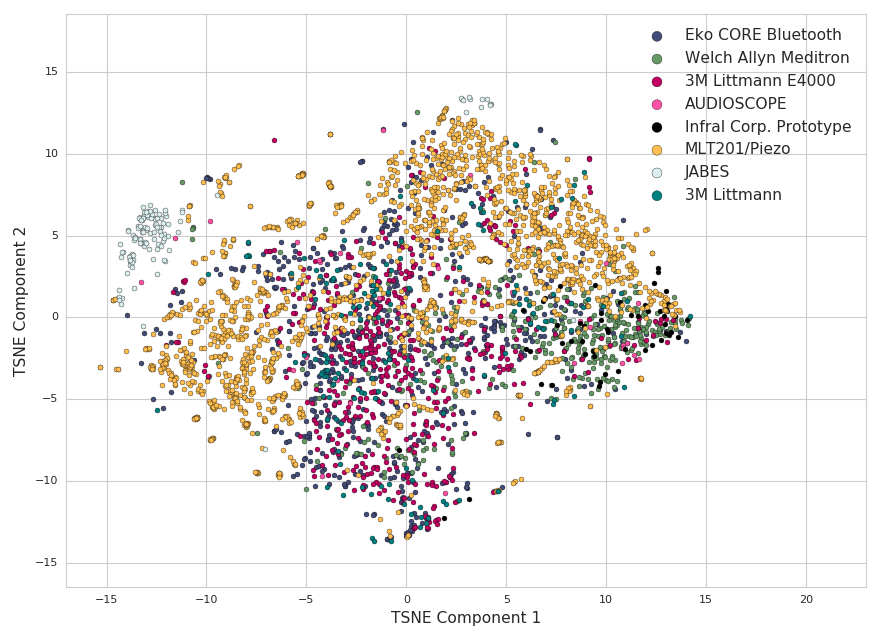

In [21]:
sns.set_style('whitegrid')
import matplotlib.font_manager as font_manager
font_prop = font_manager.FontProperties(size=14)
font_title = font_manager.FontProperties(size=20)

colors = ['#434B77',
          '#669966',
          '#c10061',
          '#ff51a5',
          'k',
          '#ffbe4f',
#           '#008080',
          '#DBEEEE',
          '#008080',
         ]
# y_ = y_>6
subsets = ["Eko CORE Bluetooth",
"Welch Allyn Meditron",
"3M Littmann E4000",
"AUDIOSCOPE",
"Infral Corp. Prototype",
"MLT201/Piezo",
"JABES",
"3M Littmann"]
parser = dict(zip(np.unique(y_),subsets))
fig = plt.figure(figsize=(11,8))
for stage,color in zip(np.unique(y_),colors):
    mask = y_ == stage
    plt.scatter(X_embedded[mask,0],X_embedded[mask,1],c=color,label=parser[stage])
plt.legend(markerscale=2,fontsize=14)
fig.set_tight_layout(tight=1)
plt.xlabel('TSNE Component 1',fontproperties=font_prop)
plt.ylabel('TSNE Component 2',fontproperties=font_prop)
plt.show()

In [ ]:
fig = plt.figure(figsize=(7,5))
conf = model_confidence(model,x_val,y_val)
conf = cc2parts(conf,val_parts)
plt.hist(conf)
plt.show()

In [ ]:
potes = "/media/taufiq/Data1/Heart_Sound/Physionet/answers.txt"
pdf = pd.read_csv(potes, header=None)
pdf.set_index(0,inplace=True)
gt = "/media/taufiq/Data1/Heart_Sound/Physionet/2016-07-25_Updated files for Challenge 2016/Online Appendix_training set.csv"
gtdf = pd.read_csv(gt)
gtdf.set_index('Challenge record name',inplace=True)
pdf = pdf.join(gtdf,how='left')
files = pdf.index.str
calc_metrics(true=pdf['Class (-1=normal 1=abnormal)']>0,pred=pdf[1]>0,files=pdf.index.str[0])

## Grad-CAM

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
def grad_cam_rec(model,layer_name,cc,label,output_class='true',normalize=True,verbose=0):
    '''
    Generate class activation maps for whole recording
    
    Inputs:
    model: model object
    layer_name: layer to take grads of
    cc: segmented cardiac cycles
    label: corresponding class for each cc to generate activations w.r.t
    
    Outputs:
    rec: concatenated cc
    acti: concatenated CAMs
    '''
    
    rec = []
    activations = []
    for idx,data in enumerate(cc):
        if verbose:
            print("Grad-CAM on CC-%d" % idx)
        data = np.expand_dims(data,axis=0)
        
        if output_class == 'true':
            output = model.output[:,-(int(label[idx])+1)]
        elif output_class == 'pred':
            pred = np.argmax(model.predict(data,verbose=0),axis=-1)
            output = model.output[:,-(int(pred)+1)]
        else:
            raise ValueError('output_class should be `true` or `pred`')
        
        last_conv_layer = model.get_layer(layer_name) ##### have to change the name here
        grads = K.gradients(output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1)) ### no idea what to do here
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

        pooled_grads_value, conv_layer_output_value = iterate([data])
        for i in range(pooled_grads_value.shape[0]):
            if verbose:
                print("Iteration %d" % i)
            conv_layer_output_value[ :, i] *= pooled_grads_value[i]
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        if normalize:
            print('normalizing')
            try:
                heatmap /= (np.std(heatmap)+ 1E-10)
            except RuntimeWarning:
                heatmap = heatmap
        
        
        x = np.linspace(0, data.shape[1], num=len(heatmap))
        y = heatmap
        f1 = interp1d(x, y, kind='cubic')
        xnew = np.linspace(0, data.shape[1], num=data.shape[1])
        ynew = f1(xnew)
        
        end_idx = np.where(data!=0)[1][-1]
        data = data[0,:end_idx,0]
        ynew = ynew[:end_idx]
        rec.append(data)
        activations.append(ynew)
    
    return np.asarray(np.hstack(rec)),np.asarray(np.hstack(activations))

def grad_cam_logs(logs,layer_name,cc,label,min_epoch=80,min_metric=.7,output_class='true',normalize=True,
                  xlim=None,figsize=(12,8),lognames=None,colors=None,window='flat',win_size=50,
                metric='val_macc',model_dir='/media/taufiq/Data1/heart_sound/models/',verbose=0):
    '''
    Plot Grad_CAM for logs with predictions
    '''
    parser={0:'Normal',1:'Abnormal'}
    
    if not type(logs) == list:
        logs = [logs]
    
    activations = []
    predictions = []
    for log_name in logs:
        model = load_model(log_name,verbose=verbose)
        weights = get_weights(log_name,min_epoch=min_epoch,
                              min_metric=min_metric,verbose=verbose)
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)
        if verbose:
            print("GRAD CAM for %s" % log_name)
        _,acti = grad_cam_rec(model,layer_name,cc,label,
                              verbose=verbose,
                              normalize=normalize,
                              output_class=output_class)
        pred = cc2rec_labels(cc,model.predict(cc)[:,1])
        activations.append(acti)
        predictions.append(pred)
    
    rec = cc2rec(cc)
    
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2,)
    main_ax = fig.add_subplot(grid[0,:],
                              ylabel='PCG',
#                               ylabel='%s PCG'%parser[label[0]]
                             )
    pred_ax = fig.add_subplot(grid[1, :], ylabel='Predictions', sharex=main_ax)
    acti_ax = fig.add_subplot(grid[2, :], ylabel='Activations', sharex=main_ax)
    

    t = np.linspace(0,len(rec)/1000,num=len(rec))
    main_ax.plot(t,rec)
    main_ax.set_xlim([0,t[-1]])
    
    if colors is not None:
        for acti,pred,color in zip(activations,predictions,colors):
            acti_ax.plot(t,smooth_win(acti/np.std(acti),window_len=win_size,window=window),color=color)
            pred_ax.plot(t,pred,color=color)
            
    else:
        for acti,pred in zip(activations,predictions):
            acti_ax.plot(t,smooth_win(acti/np.std(acti),window_len=win_size,window=window))
            pred_ax.plot(t,pred)
    
    pred_ax.set_ylim([0,1])
    if xlim is not None:
        main_ax.set_xlim(xlim)
    if lognames is not None:
        acti_ax.legend(lognames)
        
    return [main_ax,pred_ax,acti_ax]

def smooth_win(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError, "smooth only accepts 1 dimension arrays."
        if x.size < window_len:
                raise ValueError, "Input vector needs to be bigger than window size."
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

In [ ]:
fig = plt.figure(figsize=(6,6))
conf = model_confidence(model=model,data=x_val,labels=y_val, verbose=1)
conf = cc2parts(conf,val_parts)
plt.hist(conf,40)
plt.show()

In [ ]:
cond = np.logical_and(conf>.8,conf<.9)
_,idx = np.where([cond])
print('Number of Recordings within condition',len(idx))

target_idx = np.random.randint(len(idx))
print('Target Recording from subset-',cc2parts(val_files,val_parts)[idx[target_idx]])

cc_idx = idx_parts2cc([idx[target_idx]],val_parts)

target_data = x_val[cc_idx]
target_labels = y_val[:,1][cc_idx]
print('Target Recording Class',target_labels[0])
target_data.shape

#### Inspect Training Sample

In [ ]:
np.linspace(0,len(target_data)/1000,num=len(target_data))

In [ ]:
cc2parts(train_files,train_parts).shape

In [ ]:
target = 'a0182.wav'

filenames = pd.read_csv('/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/train_files.txt',header=None)
idx = np.where(filenames[0]==target)[0]
print(idx)
cc_idx = idx_parts2cc(idx,train_parts)
target_data = x_train[cc_idx]
target_labels = y_train[:,1][cc_idx]
print('Target Recording Class',target_labels[0])
print('Number of cc',target_data.shape[0])

fig = plt.figure()
rec = cc2rec(target_data[:6])
plt.plot(np.linspace(0,len(rec)/1000,num=len(rec)),rec)
plt.show()

#### Inspect Validation Sample

In [ ]:
target = 'b0003'
filenames = pd.read_csv('/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation0.txt',header=None)
idx = np.where(filenames[0]==target)[0]
cc_idx = idx_parts2cc(idx,val_parts)

target_data = x_val[cc_idx]
target_labels = y_val[:,1][cc_idx]
print('Target Recording Class',target_labels[0])
print('Target Recording cc',target_labels.shape)
target_data.shape

fig = plt.figure()
rec = cc2rec(target_data)
plt.plot(np.linspace(0,len(rec)/1000,num=len(rec)),rec)
plt.show()

#### Inspect Test Sample

In [ ]:
idx = 188
cc_idx = idx_parts2cc(idx,test_parts)

target_data = x_test[cc_idx]
target_labels = y_test[:,1][cc_idx]
print('Target Recording Class',target_labels[0])
target_data.shape

In [ ]:
logs=[
"potes_fold0_noFIR 2019-03-16 18:44:45.597226", # potes non balanced
"potes_fold0_noFIR 2019-03-02 13:01:33.636778", # potes
"fold0_noFIR 2019-02-27 19:52:21.543329", # Type1 macc
# "fold0_noFIR 2019-03-07 14:44:47.022240", # Type2 macc 80 epoch
# "fold0_noFIR 2019-03-08 03:28:46.740442", # Type3 sensitivity
# "fold0_noFIR 2019-03-08 14:50:52.332924", # type4 val_acc
# "fold0_noFIR 2019-03-09 01:34:03.547265", # gamma stage 1
"fold0_noFIR 2019-03-06 14:21:29.823568", # zero stage2
]
lognames=[
"Potes-CNN",
"Potes-CNN DBT",
"Type I tConv",
# "Type II tConv",
# "Type III tConv",
# "Type IV tConv",
# "Gammatone tConv",
"Zero Phase tConv",
]
colors = [
'#434B77',
'#669966',
'#c10061',
'#ff51a5',
'k',
'#ffbe4f',
'#DBBBBB',
'#008080',
         ]

cc_start = 0
cc_end = 8
ax = grad_cam_logs(logs,'concatenate_1',target_data[cc_start:cc_end],target_labels[cc_start:cc_end],win_size=10,
                   lognames=lognames,colors=colors,output_class='pred',normalize=True)
ax[1].set_yticks([0,.25,.5,.75,1])

In [ ]:
fig = plt.gcf()
fig.set_size_inches(3.5,5)
ax[1].set_yticks([0,.25,.5,.75,1])
ax[2].set_ylim([-.1,6])
# fig.savefig('Normal.eps')

# plt.savefig('MRgradCAM.eps')
# plt.xlim([0,4.7])

ax[2].legend_ = None
# ax[2].legend(lognames)

## Error Analysis

In [ ]:
def plot_confidence_logs(logs,lognames,bins=5,figsize=(10,2),verbose=0):
    fig,ax = plt.subplots(1,len(logs),sharey='row',figsize=figsize)
    for axes,log_name,model_name in zip(ax,logs,lognames):
        model = load_model(log_name,verbose=0)
        weights = get_weights(log_name,min_epoch=100,min_metric=.7)
        metric = 'val_macc'
        model_dir = '/media/taufiq/Data1/heart_sound/models/'
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)

        for subset in np.unique(val_files):
            mask = np.asarray(val_files) == subset
            part_mask = cc2parts(val_files,val_parts) == subset
            conf = model_confidence(model=model,data=x_val[mask],labels=y_val[mask], verbose=verbose)
            conf = cc2parts(conf,val_parts[part_mask])
            sns.distplot(conf,bins=bins,label="Subset-%s"%subset,ax=axes)

        conf = model_confidence(model=model,data=x_test,labels=y_test, verbose=verbose)
        conf = cc2parts(conf,test_parts)
        sns.distplot(conf,bins=bins,label='HSSDB',ax=axes)
        axes.set_title('%s C-DIST'%model_name)
#         axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),&nbsp; shadow=True, ncol=2)
    return ax
ax = plot_confidence_logs(logs,lognames)

In [ ]:
chartBox = ax[2].get_position()
# ax[0].set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax[2].legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)